In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from preprocess import make_dataset
import torch.optim as optim
from model import *
from torch.utils.data import Dataset, DataLoader


In [2]:
class CustomDataset(Dataset):
    def __init__(self, IR_dataset, distance_dataset, ground_truth):
        self.IR_dataset = IR_dataset
        self.distance_dataset = distance_dataset
        self.ground_truth = ground_truth

    def __len__(self):
        return len(self.IR_dataset)

    def __getitem__(self, idx):
        IR_data = self.IR_dataset[idx]
        distance_data = self.distance_dataset[idx]
        label = self.ground_truth[idx]
        # 将标签转换为one-hot编码
        label_one_hot = torch.zeros(LABEL_NUM)
        label_one_hot[label] = 1
        return IR_data, distance_data, label_one_hot


In [3]:
# 转换为PyTorch张量并缩放数据
def scale_IR(dataset):
    tensor = torch.tensor(dataset, dtype=torch.float32)
    max_val = 35. # tensor.max()
    min_val = 15. # tensor.min()
    scaled_tensor = (tensor - min_val) / (max_val - min_val)
    return scaled_tensor, max_val, min_val



In [4]:
sampled_distance_dataset, sampled_IR_dataset, groudtruth = make_dataset()
# 示例数据转换
distance_tensor = torch.tensor(np.stack(sampled_distance_dataset, axis=0), dtype=torch.float32)
IR_tensor, max_IR, min_IR = scale_IR(np.stack(sampled_IR_dataset, axis=0))


distance length is 246
IR length is 246
gt length is 246
Distance dataset 1: 127, (14, 2)
IR dataset 1: 127, (9, 64)
gt dataset 1: 127
Distance dataset 2: 127, (14, 2)
IR dataset 2: 127, (9, 64)
gt dataset 2: 127


In [5]:

# 创建数据集和数据加载器
dataset = CustomDataset(IR_tensor, distance_tensor, groudtruth)
# dataloader = DataLoader(dataset, batch_size=BATCH, shuffle=True)


In [6]:
from torch.utils.data import random_split

# 随机分割训练集和测试集，假设80%为训练集，20%为测试集
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 创建数据加载器
train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)


In [7]:

# 实例化网络
net = MyMLP().cuda()
# net = MyCNN().cuda()

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [8]:
loss_history = []
# 训练循环示例
for epoch in range(1000):
    running_loss = 0.0
    for i, (IR_data, distance_data, labels) in enumerate(train_dataloader, 0):
        IR_data = IR_data.cuda()
        distance_data = distance_data.cuda()
        labels = labels.cuda()
        # 清零梯度
        optimizer.zero_grad()

        # 前向传播
        outputs = net(IR_data, distance_data)
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 更新权重
        optimizer.step()

        # 打印统计信息
        running_loss += loss.cpu().item()
        if i % 20 == 19:  # 每10个批次打印一次
            loss_mean = running_loss / 20
            loss_history.append(loss_mean)
            print(f"[{epoch + 1}, {i + 1}] loss: {loss_mean:.3f}")
            running_loss = 0.0


[1, 20] loss: 1.604
[2, 20] loss: 1.553
[3, 20] loss: 1.475
[4, 20] loss: 1.426
[5, 20] loss: 1.410
[6, 20] loss: 1.387
[7, 20] loss: 1.349
[8, 20] loss: 1.324
[9, 20] loss: 1.295
[10, 20] loss: 1.269
[11, 20] loss: 1.248
[12, 20] loss: 1.241
[13, 20] loss: 1.245
[14, 20] loss: 1.233
[15, 20] loss: 1.233
[16, 20] loss: 1.223
[17, 20] loss: 1.229
[18, 20] loss: 1.236
[19, 20] loss: 1.226
[20, 20] loss: 1.228
[21, 20] loss: 1.230
[22, 20] loss: 1.226
[23, 20] loss: 1.226
[24, 20] loss: 1.218
[25, 20] loss: 1.223
[26, 20] loss: 1.222
[27, 20] loss: 1.227
[28, 20] loss: 1.228
[29, 20] loss: 1.223
[30, 20] loss: 1.222
[31, 20] loss: 1.221
[32, 20] loss: 1.211
[33, 20] loss: 1.220
[34, 20] loss: 1.218
[35, 20] loss: 1.217
[36, 20] loss: 1.218
[37, 20] loss: 1.220
[38, 20] loss: 1.219
[39, 20] loss: 1.216
[40, 20] loss: 1.220
[41, 20] loss: 1.215
[42, 20] loss: 1.214
[43, 20] loss: 1.211
[44, 20] loss: 1.211
[45, 20] loss: 1.212
[46, 20] loss: 1.202
[47, 20] loss: 1.222
[48, 20] loss: 1.202
[

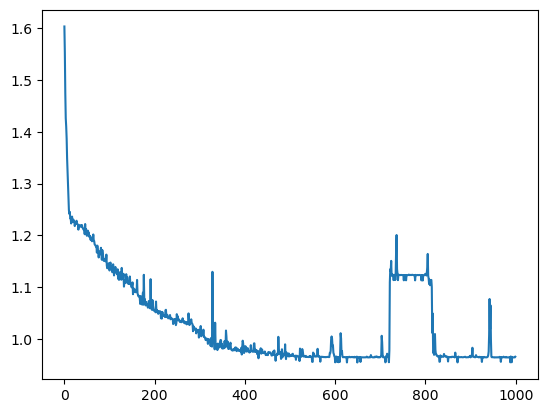

In [9]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.show()

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 测试循环
true_labels = []
predicted_labels = []
with torch.no_grad():
    for i, (IR_data, distance_data, labels) in enumerate(test_dataloader):
        IR_data = IR_data.cuda()
        distance_data = distance_data.cuda()

        outputs = net(IR_data, distance_data)
        outputs = outputs.cpu()

        _, predicted = torch.max(outputs.data, 1)
        _, gt = torch.max(labels.data, 1)
        
        true_labels.extend(gt.numpy())
        predicted_labels.extend(predicted.numpy())

# 计算性能指标
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1) # macro
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=1)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.8462
Precision: 0.8484
Recall: 0.8462


In [11]:

# 计算每个类别的精确度和召回率
precision_per_class = precision_score(true_labels, predicted_labels, average=None, zero_division=0)
recall_per_class = recall_score(true_labels, predicted_labels, average=None, zero_division=0)

# 打印结果
print(f"Precision per class: {precision_per_class}")
print(f"Recall per class: {recall_per_class}")

Precision per class: [0.84615385 0.8        0.875     ]
Recall per class: [1.  0.8 0.7]


In [12]:
from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
cm = confusion_matrix(true_labels, predicted_labels)

print("混淆矩阵:")
print(cm)

混淆矩阵:
[[11  0  0]
 [ 0  4  1]
 [ 2  1  7]]


In [13]:
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")

Total parameters: 3389


In [14]:
torch.save(net.state_dict(), 'checkpoints/high/F9-14-8-MLP221-Fea4-24-gap32.pth')